In [1]:
import numpy as np
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt

#import keras_metrics
from imgaug import augmenters as iaa

#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1)

Using TensorFlow backend.


In [2]:
x_train = np.load("x_train__aug_200.npy")
y_train = np.load("y_train_aug_200.npy")
x_train.shape, y_train.shape

((198414, 200, 200, 3), (198414, 2))

In [3]:
x_val = np.load("x_val_200.npy")
y_val = np.load("y_val_200.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [4]:
x_test = np.load("x_test_200.npy")
y_test = np.load("y_test_200.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [5]:
img = x_train[50]
img.shape

(200, 200, 3)

In [6]:
print(x_train.shape, y_train.shape)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2)
(2756, 200, 200, 3) (2756, 200, 200, 3) (2756, 2) (2756, 2)


In [6]:
IMAGE_SIZE = x_train.shape[1]
IMAGE_SIZE

200

In [7]:
def pad_image_for_square( img ):
    (rows, cols, dim) = img.shape
    resize_dim = max( rows, cols)
    pad_row = resize_dim - rows
    pad_col = resize_dim - cols
    img = np.pad(img, ((0,pad_row), (0, pad_col), (0,0)), 'constant', constant_values=0)
    return img

In [8]:
# model with only the SOFTMAX layer frozen, unconventional wisdom kicks in!
def get_model_exp2_b():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model.trainable = False
    X = base_model.output
    X.trainable = False
    
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.5)(X)
    predictions = Dense(2, activation='softmax', trainable=True)(X)
    
    # this was before
    # predictions = Dense(2, activation='softmax',trainable=False)(X)
    
    for layer in base_model.layers[-4:]:
        layer.trainable=False
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = None
model=get_model_exp2_b()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [9]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2) (2756, 200, 200, 3) (2756, 2) (2756, 200, 200, 3) (2756, 2)


In [0]:
!rm -f "vgg16_2b.h5"

In [0]:
!ls

kaggle.json  sample_data  x_train.npy  y_test.npy   y_val.npy
malaria.zip  x_test.npy   x_val.npy    y_train.npy


In [ ]:
model=get_model_exp2_b()
path_model='vgg16_aug_200.h5'  

# set the learning rate
K.set_value(model.optimizer.lr, 0.01) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=64, 
            epochs=50, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            )


Train on 198414 samples, validate on 2756 samples
Epoch 1/50
198414/198414 [==============================] - 2865s 14ms/step - loss: 0.2080 - acc: 0.9249 - val_loss: 0.1087 - val_acc: 0.9626
Epoch 2/50
198414/198414 [==============================] - 2860s 14ms/step - loss: 0.1542 - acc: 0.9440 - val_loss: 0.1011 - val_acc: 0.9652
Epoch 3/50
198414/198414 [==============================] - 2851s 14ms/step - loss: 0.1358 - acc: 0.9504 - val_loss: 0.1002 - val_acc: 0.9659
Epoch 4/50
198414/198414 [==============================] - 2839s 14ms/step - loss: 0.1225 - acc: 0.9551 - val_loss: 0.1043 - val_acc: 0.9652
Epoch 5/50
198414/198414 [==============================] - 2856s 14ms/step - loss: 0.1105 - acc: 0.9598 - val_loss: 0.0885 - val_acc: 0.9684
Epoch 6/50
198414/198414 [==============================] - 2855s 14ms/step - loss: 0.1010 - acc: 0.9630 - val_loss: 0.0961 - val_acc: 0.9717
Epoch 7/50
198414/198414 [==============================] - 2856s 14ms/step - loss: 0.0909 - acc: 

In [12]:
model.save("vgg16_200.h5")

In [0]:
# loss: 3.0371e-05 - acc: 1.0000 - val_loss: 0.2597 - val_acc: 0.9699 ---- lr = 0.01
# loss: 2.5907e-06 - acc: 1.0000 - val_loss: 0.2381 - val_acc: 0.9717 ----> lr=0.1
# loss: 5.0338e-06 - acc: 1.0000 - val_loss: 0.2631 - val_acc: 0.9713  ----> lr=0.15
# loss: 0.1247 - acc: 0.9581 - val_loss: 0.1288 - val_acc: 0.9565 ---> lr=0.0001

In [0]:
#precision = keras_metrics.precision()
#recall = keras_metrics.recall()
#f1 = keras_metrics.f1_score()

#metrics=[precision, recall, f1, 'acc']

In [13]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('vgg_graph_loss.jpg', dpi=300)
    plt.show()
    
def plot_loss(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('vgg_graph_acc.jpg', dpi=300)
    plt.show()

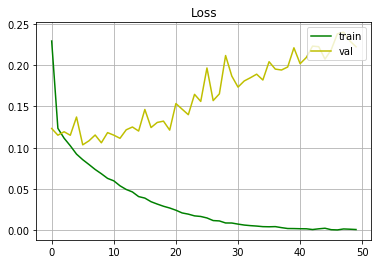

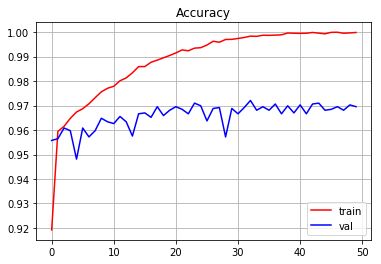

Done!


In [14]:
plot_loss_accu(model.history)
plot_loss(model.history)
print("Done!")

In [15]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2756/2756 [==============================] - 16s 6ms/step
Test loss: 0.16201102516424906
Test accuracy: 0.9764150943396226


In [16]:
y_pred = model.predict(x_test)
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])
#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
accuracy = np.mean((y_test==pred_labels))


In [17]:
accuracy

0.9764150943396226